## Titanic with Pandas, TensorFlow and other methods

First, import some useful modules

In [1]:
%matplotlib notebook
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns  # use seaborn, see https://stanford.edu/~mwaskom/software/seaborn/
import re
import pylab
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
import tensorflow as tf
import tensorflow.contrib.learn.python.learn as learn
import random

Load the training data set into a pandas data frame and see how many records are there and what is in the data

In [2]:
training_df = pd.read_csv("train.csv")
training_df.shape

(891, 12)

Show first 5 rows of the data frame:

In [3]:
training_df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Let's extract first names, surnames and titles into additional columns. Note that we use regular expressions.

In [4]:
training_df["First_Name"] = training_df["Name"].apply(lambda _: _.split()[2])
training_df["Surname"] = training_df["Name"].apply(lambda _: _.split(",")[0])
training_df["Title"] = training_df["Name"].apply(lambda _: re.findall(",\s+(\w+)\.",_)[0] if len(re.findall(",\s+(\w+)\.",_)) > 0 else None)

Check that the columns have actually been added

In [5]:
training_df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,First_Name,Surname,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Owen,Braund,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,John,Cumings,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Laina,Heikkinen,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Jacques,Futrelle,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,William,Allen,Mr


What to do about the missing values? Let's check how manuy of these we've got.

In [6]:
training_df.count()  # this returns the number of non-NA/null observations in each column

PassengerId    891
Survived       891
Pclass         891
Name           891
Sex            891
Age            714
SibSp          891
Parch          891
Ticket         891
Fare           891
Cabin          204
Embarked       889
First_Name     891
Surname        891
Title          890
dtype: int64

Obviously, all looks good. Recall that the total number of records is 891, so any variable with less that 891 has some missing values. Apparently, Age is a bit of a problem and Cabin largely contains missing values. So, what are these Cabin values? Have a closer look..

In [7]:
training_df["Cabin"].unique()  # unique values in Cabin column

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6', 'C23 C25 C27',
       'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33', 'F G73', 'E31',
       'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101', 'F E69', 'D47',
       'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4', 'A32', 'B4',
       'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35', 'C87', 'B77',
       'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19', 'B49', 'D',
       'C22 C26', 'C106', 'C65', 'E36', 'C54', 'B57 B59 B63 B66', 'C7',
       'E34', 'C32', 'B18', 'C124', 'C91', 'E40', 'T', 'C128', 'D37',
       'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44', 'A34', 'C104', 'C111',
       'C92', 'E38', 'D21', 'E12', 'E63', 'A14', 'B37', 'C30', 'D20',
       'B79', 'E25', 'D46', 'B73', 'C95', 'B38', 'B39', 'B22', 'C86',
       'C70', 'A16', 'C101', 'C68', 'A10', 'E68', 'B41', 'A20', 'D19',
       'D50', 'D9', 'A23', 'B50', 'A26', 'D48', 'E58', 'C126', 'B71',
       'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63', 'C62 C64', 'E24',

Ok, so these are a letter with some number. It would be interesting to have a map of Titanic to see if a particulat letter or set of numbers defines an area of the ship that would seem important in relation to drawning. For example, "D" could mean the top level or, maybe, "B11" to "B34" are cabins in an area difficult to get out from or close/far from the boats.. But we don't have that map right now so it's reasonable to simply ignore the "Cabin" column.

What about Age? We could just set all absent age values to 0 or ignore all records where Age is not available. However, that seems not quite right.. We could approximate the age based on Title. How often do we see records with no age but some title present?

In [8]:
len(training_df[training_df["Age"].isnull() & training_df["Title"].notnull()].index)

177

Note that 714 records do have Age (as we noticed before) and if we approximate another 177, we will get all 891 Age values.

In [9]:
aver_age_miss = round(training_df[~training_df["Age"].isnull()  & (training_df["Title"].isin(["Miss","Ms"]))]["Age"].mean(),1)
print("average age for a Miss is {}".format(aver_age_miss))

average age for a Miss is 21.8


In [10]:
aver_age_mrs = round(training_df[~training_df["Age"].isnull()  & (training_df["Title"].isin(["Mrs"]))]["Age"].mean(),1)
print("average age for a Mrs is {}".format(aver_age_mrs))

average age for a Mrs is 35.9


We get nan here because there are no Mrs with Age in our dataset! Ok then..

In [11]:
aver_age_mr = round(training_df[~training_df["Age"].isnull()  & (training_df["Title"].isin(["Mr"]))]["Age"].mean(),1)
print("average age for a Mr is {}".format(aver_age_mr))

average age for a Mr is 32.4


Alright. Let us insert the substitutes for the missing Age values. We will assign an average age for Mr to Mrs too..

In [12]:
miss_idx = training_df["Title"].isin(["Miss","Ms"])  # rows where we have Miss or Ms
training_df.loc[miss_idx,"Age"].fillna(aver_age_miss)
mrs_idx = training_df["Title"].isin(["Mr","Mrs"])
training_df.loc[mrs_idx,"Age"].fillna(aver_age_mr)
training_df.count()
training_df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,First_Name,Surname,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Owen,Braund,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,John,Cumings,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Laina,Heikkinen,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Jacques,Futrelle,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,William,Allen,Mr


<IPython.core.display.Javascript object>


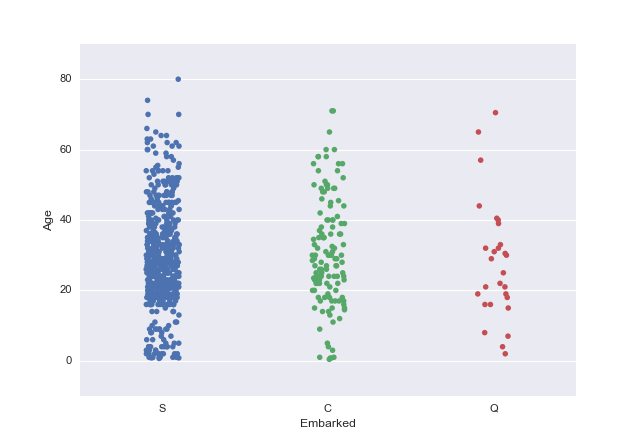

In [13]:
plt.figure()
sns.stripplot(x="Embarked", y="Age", data=training_df, jitter=True);

In [14]:
sns.set(style="whitegrid")

Let's look at the age passengers split by sex

<IPython.core.display.Javascript object>


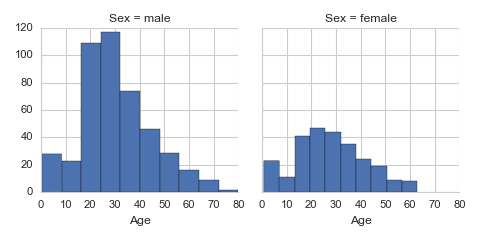

In [15]:
sns.FacetGrid(training_df, col="Sex").map(plt.hist, "Age")

<IPython.core.display.Javascript object>


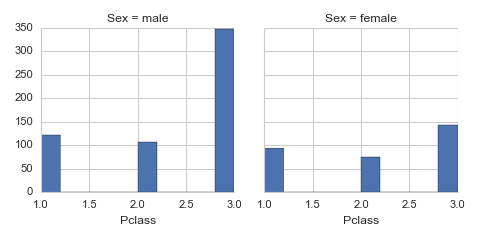

In [22]:
sns.FacetGrid(training_df, col="Sex").map(plt.hist, "Pclass")

<IPython.core.display.Javascript object>


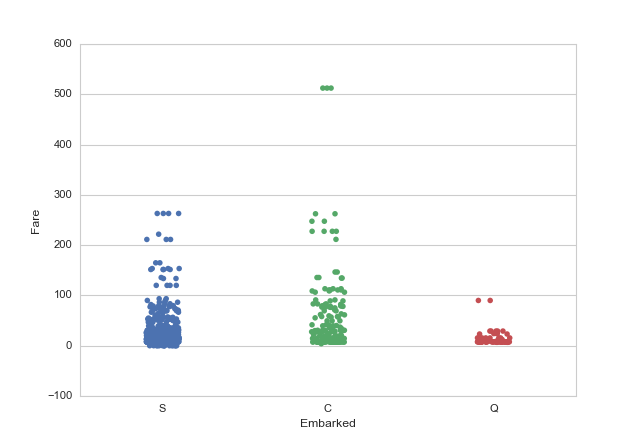

In [16]:
plt.figure()
sns.stripplot(x="Embarked", y="Fare",data=training_df, jitter=True);

It looks like the majority of passengers embarked in S and C and the fares were more or less the same at S and C. In Q, considerably fewer people embarked and they had the cheapest tickets.

### Split training data into the training and testing datasets

In [17]:
X = training_df[['Age', 'SibSp', 'Fare']].fillna(0)  # variables
y = training_df['Survived']  # outcome

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Logictic Regression

In [18]:

lr = LogisticRegression()
lr.fit(X_train, y_train)

print(accuracy_score(y_test, lr.predict(X_test)))

0.664804469274


### Decision Tree

In [19]:
clf = tree.DecisionTreeClassifier()
clf.fit(X_train, y_train)
print(accuracy_score(y_test, clf.predict(X_test)))



0.653631284916


### Naive Bayes

In [20]:
nbc = GaussianNB()
nbc.fit(X_train, y_train)
print(accuracy_score(y_test, nbc.predict(X_test)))

0.664804469274


### TensorFlow Linear

In [21]:
tfc = learn.LinearClassifier(n_classes=2, feature_columns=learn.infer_real_valued_columns_from_input(X_train), 
                                    optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.05))
tfc.fit(X_train, y_train, batch_size=256, steps=500)

print(accuracy_score(y_test, tfc.predict(X_test)))

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/tensorflow/python/ops/array_ops.py:1811: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  result_shape.insert(dim, 1)


0.675977653631
